# Birds and Words: Exploring environmental influences on folk categorization

This notebook and the code within it reproduces the analyses in the paper "Birds and Words: Exploring environmental influences on folk categorization." J.T. Abbott and C. Kemp. (2020). *In Proceedings of the 42nd Annual Conference of the Cognitive Science Society*.

## Introduction and Background

Languages around the world include rich systems of names for plants and animals, and each system can be viewed as the outcome of a natural experiment in which generations of speakers have organized their local environment into categories. A classic line of work in cognitive anthropology addresses the question of how named categories reflect the structure of the local environment (Berlin, 1992; Malt, 1995). One prominent theme is that folk taxonomies often align well with Western scientific taxonomies, suggesting that folk taxonomies are shaped more by environmental structure than by the idiosyncratic needs and concerns of a particular culture (Berlin, 1992).

Much of the cognitively-oriented work on folk biology took place last century, and in recent years new data sets have made it possible to characterize the structure of the environment in ways that were previously difficult or impossible (Sullivan et al., 2009; Wilman et al., 2014). Here we draw on these resources to revisit the classic question of the relationship between named categories and the environment. We focus on birds in particular, and begin by compiling properties of the bird species in a given area (e.g., how big is each species, and how often is it observed?) We then study how these properties relate to named bird categories in the local language. In particular, we ask whether the frequency of a species influences whether the species is named, and if so whether frequency influences the form of the name for that species and how many other species it is grouped with. 

In [41]:
# load libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns

## Datasets

The literature contains detailed folk classifications of birds from several languages around the world, and we focus here on named bird categories from Zapotec (Hunn, 2008), a language spoken in Oaxaca, Mexico.  We used two data sets that characterize the frequency and size of bird species found in Oaxaca, and a third that specifies how these species are organized into named categories.

### Frequency data

Our frequency data are drawn from eBird, a citizen-science based bird observation network managed by the Cornell Lab of Ornithology (Sullivan et al., 2009).  eBird data are contributed by bird lovers (both professional and amateur) who use the site to record the time and place of bird sightings.  We used data from just the region containing the state of Oaxaca, Mexico.

We used all eBird observation of frequency from the Basic Dataset (EBD) on https://ebird.org/data/download, last accessed January 24, 2020. An observer who sees a group of 5 vultures may record both the species (e.g., *Cathartes aura*) and the number of birds in the group (5), but we treated each case like this as a single observation of the species in question. Our data for Oaxaca include 660,223 unique observations of 922 distinct species. 

In [42]:
# load ebird data
ebd_data = pd.read_csv('./data/ebird_MX-OAX_cogsci_clean.csv')
ebd_data.tail()

,COMMON NAME,SCIENTIFIC NAME
660218,House Wren,Troglodytes aedon
660219,Black-vented Oriole,Icterus wagleri
660220,Yellow-rumped Warbler,Setophaga coronata
660221,Red-tailed Hawk,Buteo jamaicensis
660222,Cattle Egret,Bubulcus ibis


In [43]:
# parse ebird data to get main list of birds in consideration
def get_birdcounts(ebd_data):
	# read ebird count and name data
	bird_counts = {}
	science_name = list(ebd_data['SCIENTIFIC NAME'])
	i=0
	for bird_name in science_name:
		if bird_name in bird_counts.keys():
			bird_counts[bird_name] +=1
		else:
			bird_counts[bird_name] = 1
		i+=1

	return bird_counts

# get bird counts, indexed by species name
bird_counts = get_birdcounts(ebd_data)

### Size data

Beyond frequency it is plausible that physical and behavioral characteristics of birds both influence folk categorizatio. Hunn (1999) has documented that smaller species are more likely to be lumped together into large categories, and that larger species are more likely to be given distinct names. Following his lead we evaluate bird size as an influence on categorization, and use size data from EltonTraits (Wilman et al., 2014) which includes information on key attributes for all 9993 extant bird species, including those from Oaxaca.  We use the body mass variable, separately sourced from (Dunning, 2007), which is defined as the geometric mean of average values provided for both sexes. Beyond body mass EltonTraits includes variables related to diet types, foraging strata, and activity patterns, and future studies can explore whether and how these variables influence naming. We include all of these features in the precompiled dataframe below. 

### Naming data

Our naming data are based on a detailed folk taxonomy of the Zapotec language provided by Hunn (2008) based on his fieldwork in San Juan Gbee, a small village in Oaxaca, Mexico (Also available online at http://faculty.washington.edu/hunn/zapotec/z5.html). Folk classifications include names at different taxonomic ranks, and our data set includes a scientific name,  a folk-specific name and a folk-generic name for each species listed. For example, *Colibri thalassinus* (Mexican violetear) is named *dzǐn̲g-yǎ-guì* (mountain hummingbird) at the folk-specific level and *dzǐn̲g* (hummingbird) at the folk-generic level.  According to Hunn's taxonomy the folk-generic category *dzǐn̲g* (hummingbird) includes 14 different species. These 14 species are partitioned into 4 categories at the folk-specific level:  *dzǐn̲g*, *dzǐn̲g-dán-yǎ-guì*, *dzǐn̲g-gué*, and *dzǐn̲g-yǎ-guì*.
As this example suggests, in some cases the folk-specific and folk-generic names for a species are identical: for example, *Amazilia Beryllina* is known simply as *dzǐn̲g* (hummingbird) at the folk-specific level. 

In total Hunn's taxonomy includes 153 species that are organized into 94 distinct folk-specific categories, which in turn are organized into 68 folk-generic categories.  The scientific species labels given by Hunn did not always match those used by our other sources of data (eBird and EltonTraits).  We took the Clements checklist (used by eBird) as our gold standard (Clements, 2007), and some manual preprocessing was required to align the labels used by all three resources.

We have precompiled this into a single dataframe (df) for the purposes of replicating these analyses.

In [44]:
# read full Zapotec data, including data on non-Zapotec birds
zapotec_data_all = pd.read_csv('./data/df_zapotec_fullfeats_cogsci2020.csv')
# make a df of only Zapotec data
zapotec_data_only = zapotec_data_all[zapotec_data_all['folk_generic'].notna()] 
zapotec_data_only.tail()

,species,common_name,mass,freq,folk_generic,folk_specific,clements_group,prototype,group_size_folk_generics,group_size_folk_specific,...,PC8,PC9,Beak_PC1,Beak_PC2,Beak_PC3,Beak_PC4,Realm,TrophicLevel,TrophicNiche,ForagingNiche
148,Eupsittula canicularis,Orange-fronted Parakeet,85.00,0,pèrícw,pèrícw,"Parrots, Parakeets, and Allies",0.0,1.0,1.0,...,-0.045009,-0.062336,1.172711,-0.842640,-0.179956,0.234493,Neotropic,Herbivore,Frugivore,Fugivore glean
149,Accipiter striatus,Sharp-shinned Hawk,130.59,862,msì,msì-lâg,"Vultures, Hawks, and Allies",0.0,7.0,3.0,...,-0.225898,-0.001699,0.349656,-0.654936,0.026132,-0.065423,Nearctic,Carnivore,Vertivore,Generalist
150,Mitrephanes phaeocercus,Tufted Flycatcher,8.59,1776,wǐt,wǐt-dán,"Tyrant Flycatchers: Pewees, Kingbirds, and Allies",0.0,12.0,1.0,...,0.018161,0.060948,-1.236871,-0.096652,0.379866,-0.041239,Neotropic,Carnivore,Invertivore,Invertivore sally air
151,Eugenes fulgens,Rivoli's Hummingbird,8.00,1642,dzǐn̲g,dzǐn̲g,Hummingbirds,0.0,14.0,10.0,...,-0.186846,0.022250,-0.249738,1.346360,0.091586,0.113709,Nearctic,Herbivore,Nectarivore,Nectarivore aerial
152,Selasphorus rufus,Rufous Hummingbird,3.50,360,dzǐn̲g,dzǐn̲g,Hummingbirds,0.0,14.0,10.0,...,-0.014249,0.036047,-1.221765,1.291873,-0.066214,0.128370,Nearctic,Herbivore,Nectarivore,Nectarivore aerial


As can be seen, this dataframe contains a number of features beyond mass, frequency, and name. 

In [45]:
zapotec_data_only.columns

Index(['species', 'common_name', 'mass', 'freq', 'folk_generic',
       'folk_specific', 'clements_group', 'prototype',
       'group_size_folk_generics', 'group_size_folk_specific',
       'group_size_clements', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7',
       'PC8', 'PC9', 'Beak_PC1', 'Beak_PC2', 'Beak_PC3', 'Beak_PC4', 'Realm',
       'TrophicLevel', 'TrophicNiche', 'ForagingNiche'],
      dtype='object')

Each row in the dataframe corresponds to a single bird, and the columns are organized as follows:
* 'species' : The scientific species name following Clements (2007), as used by eBird.
* 'common_name' : The common English name following Clements (2007), as used by eBird.
* 'mass' : The bird body mass from EltonTraits (Wilman et al., 2014), separately sourced from Dunning (2007).
* 'freq' : The bird frequency count from eBird. (from Oaxaca data last accessed January 24, 2020)
* 'folk_generic' : The folk-generic Zapotec bird name as provided by Hunn.
* 'folk_specific' : The folk-specific Zapotec bird name as provided by Hunn.
* 'clements_group' : The Clements scientific group type the bird belongs to.
* 'prototype' : Whether or not the bird was considered an unmarked-prototype by Hunn.
* 'group_size_folk_generics' : The number of other Zapotec birds with the same folk-generic name.
* 'group_size_folk_specific' : The number of other Zapotec birds with the same folk-specific name.
* 'group_size_clements': The number of other Zapotec birds with the same Clements group type.
* 'PC1' - 'PC9' : Principal components of a 9-dimensional space generated by Pigot et al. (2020), based on body mass in addition to 8 variables related to beak shape and body shape.
* 'Beak_PC1' - 'Beak_PC4' : Principal components for a 4-dimensional spaced generated by Pigot et al. (2020), based on 4 measurements of beak shape.
* 'Realm' : The biogeographic area the bird is most commonly found, from EltonTraits (Wilman et al., 2014).
* 'TrophicLevel' : The trophic level (primary food intake) of the bird, from EltonTraits (Wilman et al., 2014)
* 'TrophicNiche' : The trophic niche (how and where primary food intake occurs) of the bird, from EltonTraits (Wilman et al., 2014).
* 'ForagingNiche' : The foraging niche (how and where food intake generally occurs) of the bird, EltonTraits (Wilman et al., 2014).


We will only use a subset of these features as described in the paper, and ask whether the frequency and body mass data predict aspects of Hunn's naming data.  We focus first on the extensions of folk categories, and subsequently consider the labels or names given to these categories.




## Analysis of category extensions

Our first analysis considers whether frequency and mass predict whether a species is likely to be named. Intuitively, one might expect that common species are more likely to be named, and that larger species are especially salient perceptually and therefore more likely to be named. Most descriptions of folk classification systems in the literature do not systematically describe species found in the local area that are *not* named by the local residents. Our eBird data, however, include species that were documented in Oaxaca but not included in Hunn's taxonomy. Some of these species are probably rarely if ever seen in the village (San Juan Gbee) where Hunn carried out his fieldwork. We expect, however, that some species missing from the taxonomy would be occasionally encountered in San Juan Gbee. 

We first explore the distributions of frequency and mass for birds with and without Zapotec names.


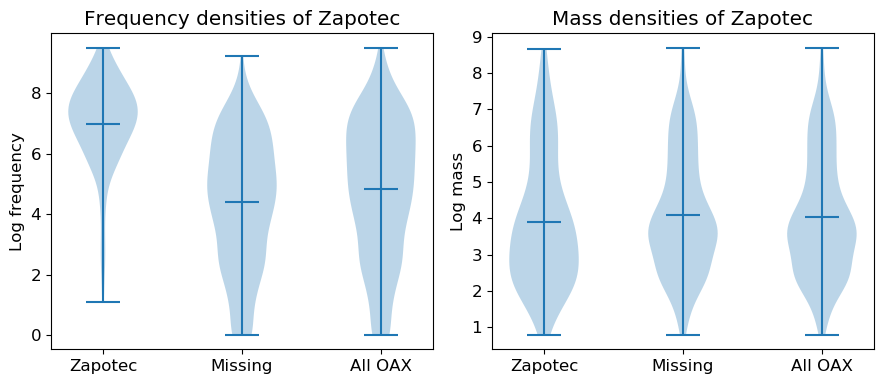

In [46]:
# Figure 1 in paper: What categories are give a name
# violin plot (with log frequency of occurrence)

# Parse the dataframe into some useful dictionaries
def get_genericlevel(zapotec_data):
	bird_sci2generic_names = {}

	generic_names = list(zapotec_data['folk_generic'])
	science_names = list(zapotec_data['species'])

	i=0
	for bird_name in science_names:
		bird_sci2generic_names[bird_name] = generic_names[i]
		i+=1

	return bird_sci2generic_names

generic_levels = get_genericlevel(zapotec_data_only)
generic_level_names = list(set(zapotec_data_only['folk_generic']))

def get_specificlevel(zapotec_data):
	bird_sci2specific_names = {}

	specific_names = list(zapotec_data['folk_specific'])
	science_names = list(zapotec_data['species'])

	i=0
	for bird_name in science_names:
		if bird_name in bird_sci2specific_names.keys():
			bird_sci2specific_names[bird_name].append(specific_names[i])
		else:
			bird_sci2specific_names[bird_name] = []
			bird_sci2specific_names[bird_name].append(specific_names[i])
		i+=1

	return bird_sci2specific_names

specific_levels = get_specificlevel(zapotec_data_only)

# create Figure 1 data
bird_list = list(zapotec_data_only['species'])
freqs = list(zapotec_data_only['freq'])

data_zapotec = [np.log(i) for i in freqs if i >0]
data_all = [np.log(i) for i in bird_counts.values()]

missing_data = []
for birdcount in bird_counts.keys():
	if birdcount not in bird_list:
		missing_data.append(np.log(bird_counts[birdcount]))

# make figure
plt.figure(figsize=(9, 4), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
plt.subplot(1,2,1)
pos = [1,2,3]
plotnames = ('Zapotec','Missing','All OAX')
plt.violinplot([data_zapotec,missing_data,data_all],pos,showmeans=True) 
plt.title('Frequency densities of Zapotec')
plt.xticks(pos,plotnames)
plt.ylabel('Log frequency')

# mass subplot
zapotec_masses = {}
for zapotec_bird in generic_levels.keys():
	mass = float(zapotec_data_only[zapotec_data_only['species'] == zapotec_bird]['mass'])  
	if mass > 0:
		zapotec_masses[zapotec_bird] = mass

oax_masses = {}
for oax_bird in bird_counts.keys():
	mass = float(zapotec_data_all[zapotec_data_all['species'] == oax_bird]['mass'])
	if mass > 0:
		oax_masses[oax_bird] = mass
              
data_zapotec = [np.log(i) for i in zapotec_masses.values()]
data_all = [np.log(i) for i in oax_masses.values()]

missing_data = []
for birdmass in oax_masses.keys():
	if birdmass not in zapotec_masses.keys():
		missing_data.append(np.log(oax_masses[birdmass]))

plt.subplot(1,2,2)
pos = [1,2,3]
plotnames = ('Zapotec','Missing','All OAX')
plt.violinplot([data_zapotec,missing_data,data_all],pos,showmeans=True) 
plt.title('Mass densities of Zapotec')
plt.xticks(pos,plotnames)
plt.ylabel('Log mass')
plt.tight_layout()
plt.show()

As expected, on average birds that are named tend to be more frequent than birds that are not named. The mass distributions for named and unnamed birds, however, are very similar. To confirm these impressions we ran a logistic regression including log frequency and log mass as predictors of a binary variable that indicates whether a species was named. The estimated coefficients were $\beta = 0.76 \pm 0.09$ (log frequency) and $\beta = 0.005 \pm 0.07$ (log mass). We compared the full logistic regression model to alternatives that removed either log frequency or log mass as a predictor, and found that removing log frequency produced a significant impairment ($\chi^{2}(1) = -123.52, p < 1e-10$), but removing log mass did not ($\chi^{2}(1) = 0.006, p = 0.94$).  Akaike information criterion (AIC) scores supported the conclusion that the model with log frequency but without log mass is the best among the three. (Please refer to stats_cogsci2020.html for statistical tests)


### Analysis of category size

Next we explore how named species are organized into categories. In particular, we explore whether the frequency and mass of a species partially predict the number of other species it is grouped with at the folk-generic level.

The *category size* of each species is defined as the total size of the folk-generic category to which it belongs. For example, *Colibri thalassinus* (Mexican violetear) is grouped with 13 other species called *dzǐn̲g* (hummingbird) at the folk-generic level, and therefore receives a category size of 14.

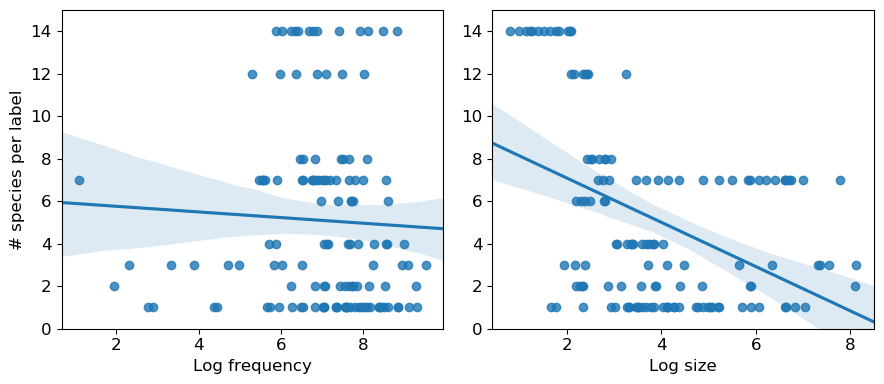

In [47]:
#
# Figure 2 in paper: category size plots
#
SSRR_species = {}
xs = []
ys = []
zs = []
for bird_species in bird_list:
    # group folk-generic levels
    if float(zapotec_data_only[zapotec_data_only['species'] == bird_species]['freq']) > 0.0:
	    generic_taxon = generic_levels[bird_species]
	    len_unique_species_in_generic = len(list(set(zapotec_data_only[zapotec_data_only['folk_generic'] == generic_taxon]['species'])))
	    SSRR_species[bird_species] = len_unique_species_in_generic
	    xs.append(float(zapotec_data_only[zapotec_data_only['species'] == bird_species]['mass']))
	    ys.append(SSRR_species[bird_species])
	    zs.append(float(zapotec_data_only[zapotec_data_only['species'] == bird_species]['freq']))
    

plt.figure(figsize=(9, 4), dpi=100, facecolor='w', edgecolor='k')
plt.title('Zapotec category organization')

plt.subplot(1,2,1)
ssrrdf = pd.DataFrame(list(zip(np.log(zs),ys)),columns =['log freq','num species'])
sns.regplot(x=ssrrdf["log freq"], y=ssrrdf["num species"])
plt.xlabel('Log frequency')
plt.ylabel('# species per label')
plt.ylim([0.,15.])
plt.yticks((0, 2, 4,6,8,10,12,14))


plt.subplot(1,2,2)
ssrrdf = pd.DataFrame(list(zip(np.log(xs),ys)),columns =['log size','num species'])
sns.regplot(x=ssrrdf["log size"], y=ssrrdf["num species"])
plt.xlabel('Log size')
plt.ylabel('')
plt.ylim([0.,15.])
plt.yticks((0, 2, 4,6,8,10,12,14))
plt.tight_layout()
plt.show()

In [48]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(zs),np.log(ys))
print("Log Freq\nslope: %f    intercept: %f, p_val: %f" % (slope, intercept,p_value))
print("Category size R-squared: %f" % r_value**2)

slope, intercept, r_value, p_value, std_err = linregress(np.log(xs),np.log(ys))
print("Log Mass\nslope: %f    intercept: %f, p_val: %f" % (slope, intercept,p_value))
print("Category size R-squared: %f" % r_value**2)

Log Freq
slope: -0.043850    intercept: 1.537600, p_val: 0.431191
Category size R-squared: 0.004810
Log Mass
slope: -0.173697    intercept: 1.910424, p_val: 0.000180
Category size R-squared: 0.103397


The figure above shows plots of category size (at the folk-generic level) against both frequency and mass, and shows that mass is a stronger predictor ($r^2 = 0.10$) than frequency ($r^2 = 0.005$). The coefficients of a linear regression also suggest that mass ($\beta = -1.18 \pm 0.20$) is a stronger predictor than frequency ($\beta = -0.55 \pm 0.23$). Comparing the full model with both predictors to models that remove one predictor, however, suggests that removing mass significantly impairs the fit of the model ($\chi^{2}(1) = 504.82, p < 1e-5$), as does removing frequency ($\chi^{2}(1) = -78.89, p < 0.05$). AIC values support this same conclusion (See stats_cogsci2020.html).


Overall these findings support Hunn's finding that larger species tend to be assigned to smaller categories, but suggest that frequency predicts category size only weakly. Our analyses, however,  did not include a third environmental factor  which probably interacts with body mass and frequency. The category size of a species almost certainly depends on how many other similar species are found in the environment. For example, one reason why *dzǐn̲g* (hummingbird) is the largest folk-generic category in our data is that Oaxaca has many species of hummingbirds that look relatively similar to each other and relatively distinct from other species in the environment. In future work we plan to further explore the influence of perceptual similarity on folk categorization systems with the additional features from Pigot et al. (2020) and EltonTraits (Wilman et al., 2014).




## Analysis of category labels

The previous section focused on category extensions, but we now ask whether frequency and mass influence the form of the names for each species. We focus on names at the folk-specific level and consider three lexical properties of these names: name length, whether the name is a compound or monomial, and whether the name is an unmarked prototype.

### Name Length

Zipf's law of brevity (1936, see also Ferrer-i-Cancho et al., 2013) is the well-established regularity that word lengths are inversely related to word frequency. Intuition suggests that the frequency with which a species is named should roughly track the frequency with which it is observed, and we therefore hypothesized that more frequent species would tend to have shorter names.  In contrast, we expected that there would be no relationship between body mass and name length. 

Because we do not have phonemic representations of the Zapotec names, we used a crude measure of length based on the number of characters in the written form of each name. We analyzed both the frequencies and masses of birds named in Zapotec in relation to the name length of the bird.

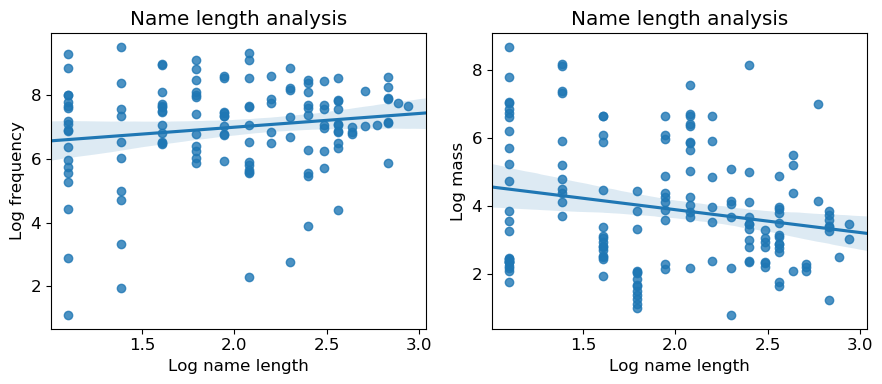

In [49]:
# relationship between length and frequency
names = list(zapotec_data_only[zapotec_data_only['freq']>0]['folk_specific'])
freqs = list(zapotec_data_only[zapotec_data_only['freq']>0]['freq'])          
xs1 = [len(i) for i in names]
ys1 = freqs
plt.figure(figsize=(9, 4), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
plt.subplot(1,2,1)
namelen_df = pd.DataFrame(list(zip(np.log(xs1),np.log(ys1))),columns =['log frequency','log name length'])
sns.regplot(x=namelen_df["log frequency"], y=namelen_df["log name length"])
plt.ylabel('Log frequency')
plt.xlabel('Log name length')
plt.title('Name length analysis')

# relationship between length and mass
names = list(zapotec_data_only['folk_specific'])
masses = list(zapotec_data_only['mass'])            
xs2 = [len(i) for i in names]
ys2 = masses
plt.subplot(1,2,2)
namelen_df = pd.DataFrame(list(zip(np.log(xs2),np.log(ys2))),columns =['log mass','log name length'])
sns.regplot(x=namelen_df["log mass"], y=namelen_df["log name length"])
plt.ylabel('Log mass')
plt.xlabel('Log name length')
plt.title('Name length analysis')
plt.tight_layout()
plt.show()

In [50]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(xs1),np.log(ys1))
print("Log Freq\nslope: %f    intercept: %f, p_val: %f" % (slope, intercept,p_value))
print("Name length R-squared: %f" % r_value**2)

slope, intercept, r_value, p_value, std_err = linregress(np.log(xs2),np.log(ys2))
print("Log Mass\nslope: %f    intercept: %f, p_val: %f" % (slope, intercept,p_value))
print("Name length R-squared: %f" % r_value**2)

Log Freq
slope: 0.430153    intercept: 6.134315, p_val: 0.073505
Name length R-squared: 0.024617
Log Mass
slope: -0.668809    intercept: 5.222261, p_val: 0.009767
Name length R-squared: 0.043394


In a direction opposite to our predictions, birds with longer names had a slight tendency to be more frequent, while having a slight tendency to be of smaller size. However, the coefficients of a linear regression suggest that log frequency ($\beta = 0.04 \pm 0.03$) and log mass ($\beta = -0.06 \pm 0.03$) are both weak predictors of log name length. Comparing the full linear regression model with both predictors to alternatives that dropped mass as a predictor significantly impaired model performance ($\chi^{2}(1) = 1.15, p < 0.03$) but dropping frequency did not ($\chi^{2}(1) = -0.48, p < 0.16$). AIC scores support the same conclusion.


### Compound names

As suggested earlier, some hummingbirds have compound names at the folk-specific level (e.g., *dzǐn̲g-yǎ-guì* (mountain hummingbird)) but others do not (e.g., *Amazilia Beryllina* is known simply as *dzǐn̲g* (hummingbird)). Compound names are notated in Hunn's taxonomy with a dash ('-'), and we explored whether frequency and mass could predict whether the folk-specific name for a species is compound or monomial. 

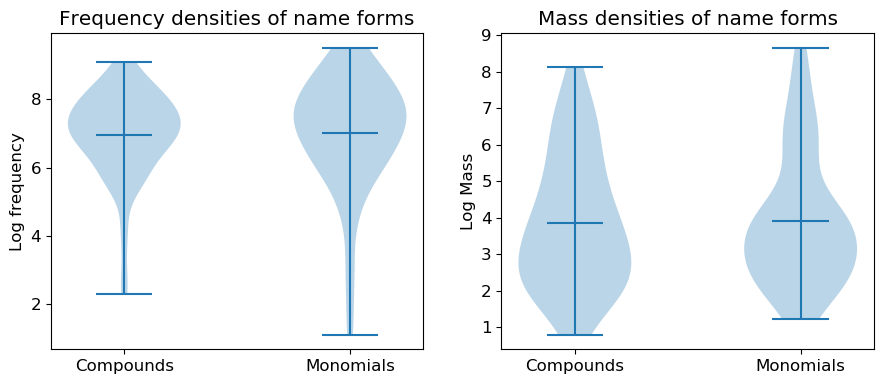

In [51]:
names = list(zapotec_data_only[zapotec_data_only['freq']>0]['folk_specific'])
freqs = list(zapotec_data_only[zapotec_data_only['freq']>0]['freq'])
monomials = []
compounds = []
for i in range(len(names)):
    if len(names[i].split('-')) > 1:
        if freqs[i] > 0:
            compounds.append(freqs[i])
    else:
        if freqs[i] > 0:
            monomials.append(freqs[i])
# violin plot 
plt.figure(figsize=(9, 4), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
plt.subplot(1,2,1)
data_compounds = [np.log(i) for i in compounds]
data_monomials = [np.log(i) for i in monomials]
pos = [1,2]
plotnames = ('Compounds','Monomials')
plt.violinplot([data_compounds,data_monomials],pos,showmeans=True)
plt.title('Frequency densities of name forms')
plt.xticks(pos,plotnames)
plt.ylabel('Log frequency')

# do the same with mass
mass = list(zapotec_data_only['mass'])
monomials = []
compounds = []
for i in range(len(names)):
    if len(names[i].split('-')) > 1:
        compounds.append(mass[i])
    else:
        monomials.append(mass[i])
data_compounds = [np.log(i) for i in compounds]
data_monomials = [np.log(i) for i in monomials]
plt.subplot(1,2,2)
pos = [1,2]
plotnames = ('Compounds','Monomials')
plt.violinplot([data_compounds,data_monomials],pos,showmeans=True)
plt.title('Mass densities of name forms')
plt.xticks(pos,plotnames)
plt.ylabel('Log Mass')
plt.tight_layout()
plt.show()

Compounds tend to be longer than monomials, and consistent with our analysis of name lengths we found 
that neither log frequency nor log mass predicts whether a species has a monomial name. The coefficients of a logistic regression suggest that log frequency ($\beta = -0.04 \pm 0.12$) is not a stronger predictor than log mass ($\beta = -0.04 \pm 0.11$), and that as the frequency or mass of a species increases it becomes less likely to have a compound name. However, comparisons of the full model to alternatives that remove either log frequency or log mass  suggest that neither predictor is significant ($\chi^{2}(1) = 0.10, p = 0.75$ for log frequency and $\chi^{2}(1) = 0.13, p = 0.72$ log mass).  AIC scores support the same conclusion. 

### Prototypes

The literature on folk categorization proposes a link between monomial labels and category prototypes (Berlin 1972, 1992). If some vultures (e.g., Turkey vulture, *Cathartes aura*) are simply called *pěch* at the folk-specific level but others have a compound name (e.g., *pěch-rúx*, or Black vulture), then vultures with the monomial name might be expected to be more typical than those given a distinctive folk-specific name. Several factors could contribute to typicality: for example, typical vultures could be those encountered most frequently, or those that are perceptually most representative of the folk-generic category *pěch* (Berlin, 1992).  Here we test the hypothesis that frequency predicts typicality.

For us, any folk-specific category (e.g., the one that includes *Cathartes aura*) with the same label as the folk-generic category to which it belongs will be called an *unmarked prototype*.  Although this definition of a prototype is based purely on linguistic form, we expect that it lines up with the psychological notion of a prototype (Rosch, 1973). Hunn's data include 11 unmarked prototypes, and for simplicity we focus on the 6 prototypes that include a single species each, which means that the species in question can be treated as a category prototype.

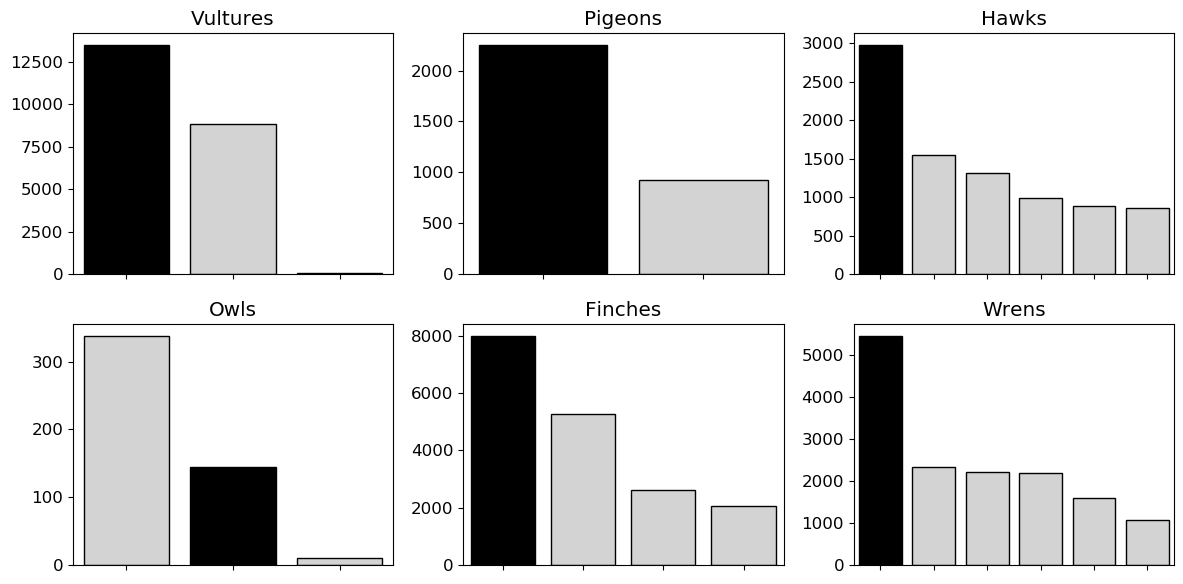

In [52]:
#
# Figure 3 in paper: Prototype plots
#

plt.rcParams.update({'font.size': 12})
def get_barheights_freq(bar_species,bird_list,df):
	heights = []
	for bird_name in bar_species:
		if bird_name in bird_list:
			heights.append(float(df[df['species'] == bird_name]['freq']))
		else:
			heights.append(0.0)

	return heights

prototypes = ['Cathartes aura','Buteo jamaicensis','Columba livia',
'Bubo virginianus','Thryomanes bewickii',
'Haemorhous mexicanus']

plt.figure(figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')

plt.subplot(2, 3, 1)
# vultures (3)
bar_species = ['Cathartes aura','Coragyps atratus','Sarcoramphus papa']
bar_labels = ('Turkey','Black','King')
subplot_title = 'Vultures'
heights = get_barheights_freq(bar_species,bird_list,zapotec_data_only)
pos = [1,2,3]
clrs = ['black','lightgrey','lightgrey']
sns.barplot(pos,heights,palette=clrs,edgecolor="Black")
plt.title(subplot_title)
plt.tick_params(labelbottom=False)

plt.subplot(2, 3, 2)
# pigeons (2)
bar_species = ['Columba livia','Patagioenas fasciata']
bar_labels = ('Rock','Band-tailed')
subplot_title = 'Pigeons'
heights = get_barheights_freq(bar_species,bird_list,zapotec_data_only)
pos = [1,2]
clrs = ['black','lightgrey']
sns.barplot(pos,heights,palette=clrs,edgecolor="Black")
plt.title(subplot_title)
plt.tick_params(labelbottom=False)

plt.subplot(2, 3, 3)
# hawks (6)
bar_species = ['Buteo jamaicensis','Accipiter cooperii','Buteo brachyurus','Buteo albonotatus','Falco peregrinus','Accipiter striatus']
bar_labels = ('Red-tailed','Coopers','Short-tailed','Zone-tailed','Peregrine Falcon','Sharp-shinned')
subplot_title = 'Hawks'
heights = get_barheights_freq(bar_species,bird_list,zapotec_data_only)
pos = [1,2,3,4,5,6]
plt.title(subplot_title)
clrs = ['black','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey']
sns.barplot(pos,heights,palette=clrs,edgecolor="Black")
plt.tick_params(labelbottom=False)

plt.subplot(2, 3, 4)
# owls (3)
bar_species = ['Ciccaba virgata','Bubo virginianus','Asio stygius']
bar_labels = ('Mottled','Great Horned','Stygian')
subplot_title = 'Owls'
heights = get_barheights_freq(bar_species,bird_list,zapotec_data_only)
pos = [1,2,3]
clrs = ['lightgrey','black','lightgrey']
sns.barplot(pos,heights,palette=clrs,edgecolor="Black")
plt.title(subplot_title)
plt.tick_params(labelbottom=False)

plt.subplot(2, 3, 5)
# finches (4)
bar_species = ['Haemorhous mexicanus','Icterus wagleri','Pheucticus melanocephalus','Piranga rubra']
bar_labels = ('House','Black-vented','Black-headed','Summer Tanager')
subplot_title = 'Finches'
heights = get_barheights_freq(bar_species,bird_list,zapotec_data_only)
pos = [1,2,3,4]
clrs = ['black','lightgrey','lightgrey','lightgrey']
sns.barplot(pos,heights,palette=clrs,edgecolor="Black")
plt.title(subplot_title)
plt.tick_params(labelbottom=False)

plt.subplot(2, 3, 6)
# wrens (6)
bar_species = ['Thryomanes bewickii','Catherpes mexicanus','Oreothlypis superciliosa','Troglodytes aedon','Henicorhina leucophrys','Salpinctes obsoletus']
bar_labels = ('Bewicks','Canyon','Crescent-chested','Brown-throated','Gray-breasted','Rock')
subplot_title = 'Wrens'
heights = get_barheights_freq(bar_species,bird_list,zapotec_data_only)
pos = [1,2,3,4,5,6]
clrs = ['black','lightgrey','lightgrey','lightgrey','lightgrey','lightgrey']
sns.barplot(pos,heights,palette=clrs,edgecolor="Black")
plt.title(subplot_title)

plt.tick_params(labelbottom=False)
plt.tight_layout()
plt.show()

The figure above shows ranked raw frequency distributions that compare the frequency of each category prototype to the frequencies of other members of the same folk-generic category. 
The top left chart indicates that the prototypical Turkey Vulture (in black) is more frequently observed in Oaxaca than other vultures. This trend holds across 5 of the 6 cases, with a notable exception for the folk-generic category including owls. Although the counts for this category are comparatively low, the unmarked prototype (Great Horned Owl) is only the second most frequent owl in the eBird data. Hunn notes that the Great Horned Owl is considered an ill-omen by many, and the cultural salience of this species may therefore explain why it receives an unmarked name despite being infrequently observed. Overall, these results suggest that Zapotec unmarked prototypes can be predicted by frequency of observation.


## Discussion and Conclusion

We drew on large-scale digital data sets to ask whether the physical size of a bird species and its frequency of occurrence predict how it is classified in a Zapotec folk taxonomy.  Our first set of analyses found that frequency (but not mass) predicts whether or not a species is named, and that both frequency and mass predict category size (i.e., how many other species a given species is grouped with at the folk-generic level). Hunn previously reported that mass predicts category size, and we found mass to be a stronger predictor than frequency. The relatively weak effect of frequency may seem at odds with previous experimental studies that report strong effects of frequency on categorization (Parducci, 1983). 

Experimental work, however, is often able to tightly control stimulus similarity, but we analyzed biological species that belong to a similarity space with rich naturalistic structure. Although perceptual similarity and frequency both affect categorization, the weak effect of frequency in our category size analysis suggests that perceptual similarity may be the stronger of the two factors.

Our second set of analyses focused on category names. Although our results suggest that frequency influences some aspects of naming (e.g., whether the folk-specific name for a species is an unmarked prototype), to our surprise, we found that frequency did not predict the length of a species' name, or whether the name is compound or monomial. Two possible explanations seem plausible. Consistent with Zipf's law of brevity, it is possible that frequently used names do tend to be short, but that these names do not pick out the species that are observed most frequently. Commonly discussed species may include cases (e.g. the bald eagle in American culture) that have cultural significance even though they are observed relatively rarely. The second possible explanation is that the effect of frequency is again dominated by perceptual similarity. For example, compound names may be most useful in "crowded" regions of perceptual space where they can serve to distinguish one species from its neighbors. In extreme cases in which a species (e.g., the Australian emu) is the only member of a folk-generic category, there is no reason to give it a compound name at the folk-specific level regardless of how frequently the species is observed.